In [110]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import boxcox
from sklearn.neighbors import KNeighborsClassifier
from sklearn.externals.six import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus


import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/Users/flatiron-school/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
df = pd.read_excel('default of credit card clients.xls', skiprows=1, index_col='ID')
df.rename({'default payment next month': 'default'}, axis=1, inplace=True)

In [3]:
# df[:9].T.head(24)

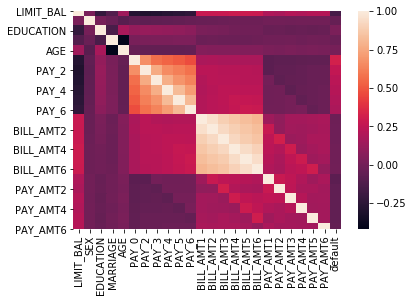

In [4]:
sns.heatmap(df.corr())

In [5]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default'],
      dtype='object')

In [6]:
df.shape

(30000, 24)

In [7]:
# Combine other small categories  
df.loc[(df.EDUCATION == 5) | (df.EDUCATION == 6) | (df.EDUCATION == 0), 'EDUCATION'] = 4

In [8]:
df.EDUCATION.value_counts()

2    14030
1    10585
3     4917
4      468
Name: EDUCATION, dtype: int64

In [9]:
# Combine to have 1:married, 2:single, 3:other
df.loc[df.MARRIAGE == 0, 'MARRIAGE'] = 3

In [10]:
df.MARRIAGE.value_counts()

2    15964
1    13659
3      377
Name: MARRIAGE, dtype: int64

In [11]:
df.rename({'PAY_0': 'pay_stat_sep', 'PAY_2': 'pay_stat_aug', 'PAY_3': 'pay_stat_jul', 'PAY_4': 'pay_stat_jun', 'PAY_5': 
           'pay_stat_may', 'PAY_6': 'pay_stat_apr'}, axis=1, inplace=True)

In [12]:
for col in df.columns:
    df.rename({'{}'.format(col): '{}'.format(col.lower())}, axis=1, inplace=True)

In [13]:
months = ['sep', 'aug', 'jul', 'jun', 'may', 'apr']
for i, c in enumerate(months):
    df[f'deferred_payment_{c}'] = np.where(df[f'pay_stat_{c}']<=0, 0, 1)

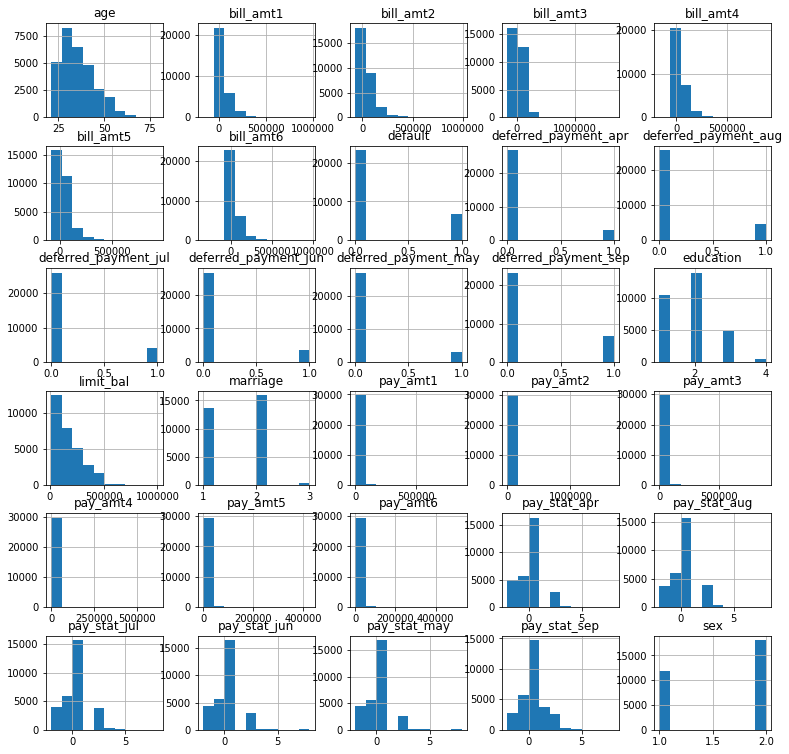

In [14]:
ax = df.hist(figsize=(13,13))

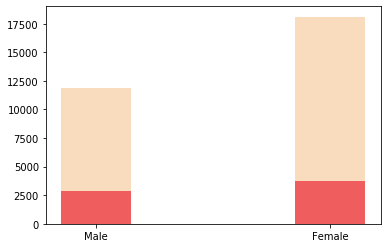

In [15]:
p1 = plt.bar(['Male', 'Female'],[df.default.loc[df['sex'] == 1].value_counts()[1], df.default.loc[df['sex'] == 2].value_counts()[1]], color='#f05d5e', width=0.3)
p2 = plt.bar(['Male', 'Female'],[df.default.loc[df['sex'] == 1].value_counts()[0], df.default.loc[df['sex'] == 2].value_counts()[0]], color='#f9dbbd', 
             bottom=[df.default.loc[df['sex'] == 1].value_counts()[1], df.default.loc[df['sex'] == 2].value_counts()[1]], width=.3)
plt.show()

In [27]:
# [df.default.loc[df['sex'] == 1].value_counts()[0], 
#                             df.default.loc[df['sex'] == 2].value_counts()[0],
#                             df.default.loc[df['sex'] == 1].value_counts()[1],
#                             df.default.loc[df['sex'] == 2].value_counts()[1]]

[9015, 14349, 2873, 3763]

In [31]:
# sns.barplot(x='default', y=[9015, 14349, 2873, 3763], hue='sex', data=df)

In [37]:
X = df.drop('default', axis=1)
y = df['default']

In [22]:
# Boxcox needs +ve non-zero data so we abs and add 1 
# (this messes with and negative amounts owed but PCA ends up not working anyway so it doesn't matter)
# Maybe adding the minimum value in the whole df to each value would be a work around

df_pca = np.abs(df) +1
df_TF = pd.DataFrame(index=df.index)
for i in df_pca.columns.values:
    df_TF["%s_TF" % i] = boxcox(df_pca.loc[:, i])[0]

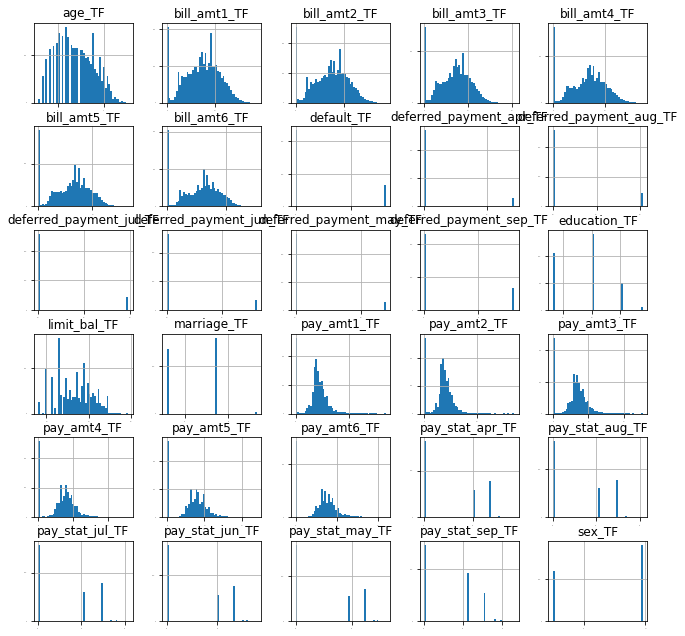

In [24]:
ax = df_TF.hist(bins=50, xlabelsize=-1, ylabelsize=-1, figsize=(11,11))

In [25]:
# Scaled to have 0 mean and sd of 1

df_TF = StandardScaler().fit_transform(df_TF)

print("mean: ", np.round(df_TF.mean(), 2))
print("standard dev: ", np.round(df_TF.std(), 2))

mean:  0.0
standard dev:  1.0


In [27]:
fit = PCA()
pca = fit.fit_transform(df_TF)

Text(0, 0.5, 'Variance Explained')

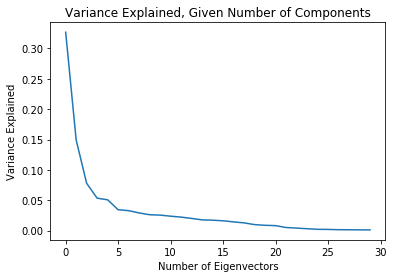

In [29]:
plt.plot(fit.explained_variance_ratio_)
plt.title("Variance Explained, Given Number of Components")
plt.xlabel("Number of Eigenvectors")
plt.ylabel("Variance Explained")

Text(0, 0.5, 'Total Variance Explained')

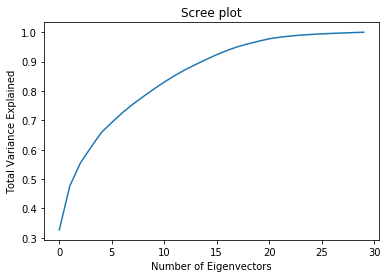

In [32]:
# We see that to get a space able to explain the majority of the data we'd need almost as many axes as the base data has.
# We therefore stop using PCA

plt.plot(np.cumsum(fit.explained_variance_ratio_))
plt.title("Scree plot")
plt.xlabel("Number of Eigenvectors")
plt.ylabel("Total Variance Explained")

In [43]:
scaler = MinMaxScaler()  

X_train_sc = scaler.fit_transform(X_train)  
X_test_sc = scaler.transform(X_test)  

In [70]:
knn1 = KNeighborsClassifier(n_neighbors=1)

In [71]:
knn1.fit(X_train_sc, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [72]:
pred1 = knn1.predict(X_test_sc)
prob1 = knn1.predict_proba(X_test_sc)

In [73]:
roc_auc_score(y_test, prob1[:,1]), roc_auc_score(y_test, pred1)

(0.6049889692322789, 0.6049889692322789)

In [79]:
knn_grid = KNeighborsClassifier(n_jobs=-1)

In [102]:

param_grid_knn = {'n_neighbors':range(6, 10),'weights':['uniform', 'distance'], 'p':range(1,10+1)}

opt_model_knn = GridSearchCV(knn_grid, param_grid_knn, cv=10, scoring='roc_auc')
opt_model_knn.fit(X_train_sc, y_train)
best_model_knn = opt_model_knn.best_estimator_

opt_model_knn.best_params_

{'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}

In [103]:
pred_knn = best_model_knn.predict(X_test_sc)
prob_knn = best_model_knn.predict_proba(X_test_sc)

In [104]:
roc_auc_score(y_test, prob_knn[:,1]), roc_auc_score(y_test, pred_knn)

(0.7374241634719172, 0.6524601826505649)

0.7374241634719172

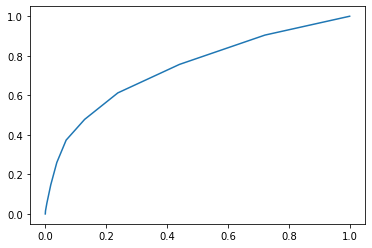

In [105]:
fpr,tpr,thr = roc_curve(y_test, prob_knn[:,1])
sns.lineplot(fpr,tpr)
auc(fpr,tpr)

In [106]:
pd.DataFrame(opt_model_knn.cv_results_).sort_values(by=['rank_test_score'])

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
60       0.108235      0.038771         0.336360        0.014082   
62       0.106569      0.033344         0.286931        0.017726   
61       0.103943      0.038319         0.342668        0.013028   
40       0.105256      0.033831         0.353317        0.023936   
63       0.104844      0.035140         0.284146        0.020678   
..            ...           ...              ...             ...   
17       0.109366      0.036593         1.347825        0.078920   
15       0.115914      0.037226         1.721091        0.285730   
19       0.105245      0.035647         1.330713        0.073868   
13       0.108260      0.036535         1.454822        0.194501   
11       0.108256      0.034054         1.387750        0.085859   

   param_n_neighbors param_p param_weights  \
60                 9       1       uniform   
62                 9       2       uniform   
61                 9       1      distance   
40                 8       1       uniform   
63                 9       2      distance   
..               ...     ...           ...   
17                 6       9      distance   
15                 6       8      distance   
19                 6      10      distance   
13                 6       7      distance   
11                 6       6      distance   

                                               params  split0_test_score  \
60   {'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}           0.733192   
62   {'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}           0.730440   
61  {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}           0.736374   
40   {'n_neighbors': 8, 'p': 1, 'weights': 'uniform'}           0.724228   
63  {'n_neighbors': 9, 'p': 2, 'weights': 'distance'}           0.734894   
..                                                ...                ...   
17  {'n_neighbors': 6, 'p': 9, 'weights': 'distance'}           0.714552   
15  {'n_neighbors': 6, 'p': 8, 'weights': 'distance'}           0.714005   
19  {'n_neighbors': 6, 'p': 10, 'weights': 'distan...           0.715297   
13  {'n_neighbors': 6, 'p': 7, 'weights': 'distance'}           0.716031   
11  {'n_neighbors': 6, 'p': 6, 'weights': 'distance'}           0.714523   

    split1_test_score  ...  split3_test_score  split4_test_score  \
60           0.715365  ...           0.715564           0.727590   
62           0.719735  ...           0.709365           0.723362   
61           0.708982  ...           0.715022           0.728663   
40           0.709127  ...           0.705914           0.726206   
63           0.711895  ...           0.709529           0.719845   
..                ...  ...                ...                ...   
17           0.702857  ...           0.695753           0.700560   
15           0.703140  ...           0.694674           0.699854   
19           0.701635  ...           0.696004           0.700030   
13           0.701543  ...           0.693651           0.700638   
11           0.702557  ...           0.694102           0.700607   

    split5_test_score  split6_test_score  split7_test_score  \
60           0.724546           0.751913           0.726890   
62           0.726900           0.749010           0.717230   
61           0.717159           0.749390           0.721898   
40           0.719367           0.745007           0.722619   
63           0.719797           0.745884           0.713489   
..                ...                ...                ...   
17           0.698142           0.722945           0.696516   
15           0.698475           0.723887           0.695429   
19           0.698156           0.722038           0.697209   
13           0.698209           0.722595           0.696372   
11           0.698793           0.722567           0.695999   

    split8_test_score  split9_test_score  mean_test_score  std_test_score  \
60           0.746177           0.728391         0.730382        0.011

In [107]:
ran_for_100 = RandomForestClassifier(n_estimators=100)

In [108]:
param_grid_ran_for_100 = {'max_depth':range(5, 12+1),'min_samples_leaf':[5,10,15]}

opt_model_ran_for_100 = GridSearchCV(ran_for_100, param_grid_ran_for_100, cv=10 ,scoring='roc_auc')
opt_model_ran_for_100.fit(X_train, y_train)
best_model_ran_for_100 = opt_model_ran_for_100.best_estimator_

opt_model_ran_for_100.best_params_

{'max_depth': 11, 'min_samples_leaf': 15}

0.7811769867224747

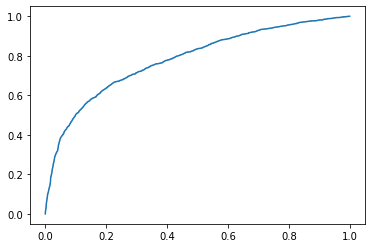

In [109]:
probas= best_model_ran_for_100.predict_proba(X_test)
fpr,tpr,thr = roc_curve(y_test,probas[:,1])
sns.lineplot(fpr,tpr)
auc(fpr,tpr)

In [115]:
best_model_ran_for_100

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=11,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=15, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=413596614, splitter='best')

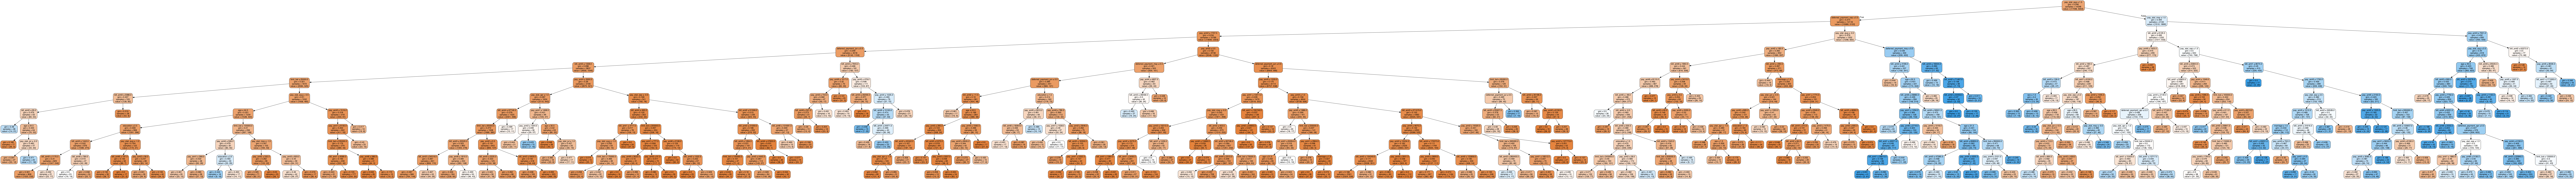

In [116]:
dot_data_tr100 = StringIO()
export_graphviz(best_model_ran_for_100[0], out_file=dot_data_tr100,  
                filled=True, rounded=True,
                special_characters=True, feature_names=X.columns)
graph = pydotplus.graph_from_dot_data(dot_data_tr100.getvalue())  
Image(graph.create_png())

In [141]:
list(zip(list(df.columns), list((best_model_ran_for_100).feature_importances_)))

[('limit_bal', 0.03152727232638337),
 ('sex', 0.0037825057973508024),
 ('education', 0.00540354116369281),
 ('marriage', 0.004071952512742247),
 ('age', 0.0193236389993725),
 ('pay_stat_sep', 0.18840082906230146),
 ('pay_stat_aug', 0.1000011236477363),
 ('pay_stat_jul', 0.052431907908240004),
 ('pay_stat_jun', 0.027988893278291068),
 ('pay_stat_may', 0.018308332052884114),
 ('pay_stat_apr', 0.014005757849427309),
 ('bill_amt1', 0.034193370872851445),
 ('bill_amt2', 0.024919218916053296),
 ('bill_amt3', 0.022688627787229562),
 ('bill_amt4', 0.022141395107476782),
 ('bill_amt5', 0.02248775764835287),
 ('bill_amt6', 0.02084988361703976),
 ('pay_amt1', 0.028689369161397915),
 ('pay_amt2', 0.024123000596616748),
 ('pay_amt3', 0.026932011758471097),
 ('pay_amt4', 0.0206502497257895),
 ('pay_amt5', 0.02125907542929271),
 ('pay_amt6', 0.02211685343500671),
 ('default', 0.12253266702554196),
 ('deferred_payment_sep', 0.04959336780386591),
 ('deferred_payment_aug', 0.03588044325040155),
 ('defer

In [140]:
best_model_ran_for_100.feature_importances_

array([0.03152727, 0.00378251, 0.00540354, 0.00407195, 0.01932364,
       0.18840083, 0.10000112, 0.05243191, 0.02798889, 0.01830833,
       0.01400576, 0.03419337, 0.02491922, 0.02268863, 0.0221414 ,
       0.02248776, 0.02084988, 0.02868937, 0.024123  , 0.02693201,
       0.02065025, 0.02125908, 0.02211685, 0.12253267, 0.04959337,
       0.03588044, 0.01399218, 0.0132959 , 0.00840887])

In [14]:
# pipe = Pipeline([('scl', MinMaxScaler()),
#                  ('pca', PCA(n_components=10)),
#                  ('svm', SVC())])

In [15]:
# grid = [{'svm__kernel': ['poly', 'sigmoid'],
#          'svm__C': [0.01, 1, 100],
#          'svm__degree0': [2,3,4,5],
#          'svm__gamma': [0.001, 0.01]}]

In [16]:
# gridsearch = GridSearchCV(estimator=pipe,
#                   param_grid=grid,
#                   scoring='accuracy',
#                   cv=3)

In [18]:
# test1 = pipe.fit(X_train, y_train)

In [ ]:
# pred1 = test1.predict(X_test)

In [ ]:
# test1.score(X_test, y_test)

In [ ]:
# roc_auc_score(y_test, pred1)